<a href="https://colab.research.google.com/github/anuragal/DepthModel/blob/master/generate_data_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount and Fetch Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Data Statistics

Utils to display file structure, directory size and image dimensions

In [3]:
import os
import cv2
import subprocess

def list_files(startpath, cap_dir=3, cap_file=3):
    dcount = 0
    for root, dirs, files in os.walk(startpath):
        dcount += 1
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        count = 0
        for f in files:
            print('{}{}'.format(subindent, f))
            count += 1
            if count == cap_file:
                print('{}{}'.format(subindent, "..."))
                break
        if dcount == cap_dir:
             print("...")
             break

def du(path):
    return subprocess.check_output(['du','-sh', path]).split()[0].decode('utf-8')

def imsize(path):
    im = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    return im.shape

Utils to compute mean and std of data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

def compute_mean_std(path, bs=128, is_gray=False):
  transforms_list = []
  if is_gray:
    transforms_list.append(transforms.Grayscale())  
  transforms_list.append(transforms.ToTensor())

  dataset = torchvision.datasets.ImageFolder(root=path,
                                             transform=transforms.Compose(transforms_list))
  loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bs,
    num_workers=4,
    shuffle=False,
    pin_memory= True
  )

  mean = 0.0
  for data, _ in tqdm(loader, desc="Computing mean"):
    batch_samples = data.size(0)
    # Flatten each channel
    data = data.view(batch_samples, data.size(1), -1)
    # Since the denominator (224*224) is constant, instead of doing sum first and
    # then taking mean, we can directly take mean and sum it.
    mean += data.mean(2).sum(0)

  mean /= len(loader.dataset)

  std = 0.0
  for data, _ in tqdm(loader, desc="Computing std"):
    batch_samples = data.size(0)
    # Flatten each channel
    data = data.view(batch_samples, data.size(1), -1)
    # Sum (x-mean)^2 per channel across all batches pixels
    std += ((data - mean.unsqueeze(1))**2).sum([0,2])

  std = torch.sqrt(std / (len(loader.dataset)*224*224))
  print("\nMean: ", mean)
  print("Std: ", std)

Utils to display images in a grid

In [2]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import glob

def show_images(images, cols = 1, titles = None, figsize=(5,5)):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=figsize)
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.axis("off")
        plt.imshow(image)
        plt.tight_layout()
        # a.set_title(title)
    # fig.set_size_inches(0.1*np.array(fig.get_size_inches()) * n_images)
    fig.tight_layout()
    plt.show()

def display_grid(base_path, n, ext=".jpg", sub_dirs=False, figsize=(5,5), off=0):
  input_files = []
  cols = int(np.sqrt(n))
  if sub_dirs:
    for bg_idx in range(off, n+off):
      path = f"{base_path}/bg_{bg_idx:02d}/*{ext}"
      input_files.append(glob.glob(path)[0])
  else:
    input_files = glob.glob(f"{base_path}/*{ext}")[:n]
  
  image_list = list(map(lambda im: imread(im), input_files))
  show_images(image_list, cols=cols, figsize=figsize)

### File Structure

In [28]:
import zipfile
import os

def extract_files(zip_file_path, zip_file_list, output_folder):
    for fp in zip_file_list:
        path_to_zip_file = os.path.join(zip_file_path, fp)
        print("Extracting zip file: %s" % path_to_zip_file)
        with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
            zip_ref.extractall(output_folder)
        print("Extracted at: %s" % output_folder)

In [29]:
# Copy Background Images to colab local directory

!rm -rf /content/bgfgdataset/bg/
!cp -r "/content/gdrive/My Drive/mask_rcnn_dataset/bg/" "/content/bgfgdataset/"
du("/content/bgfgdataset/bg")

extract_files("/content/bgfgdataset/bg", ["bg.zip"], "/content/bgfgdataset/bg")

!rm /content/bgfgdataset/bg/bg.zip

Extracting zip file: /content/bgfgdataset/bg/bg.zip
Extracted at: /content/bgfgdataset/bg


In [30]:
# Copy Foreground Images to colab local directory

!rm -rf /content/bgfgdataset/fg/
!cp -r "/content/gdrive/My Drive/mask_rcnn_dataset/fg/" "/content/bgfgdataset/"
du("/content/bgfgdataset/fg")

extract_files("/content/bgfgdataset/fg", ["fg.zip"], "/content/bgfgdataset/fg")

!rm /content/bgfgdataset/fg/fg.zip

Extracting zip file: /content/bgfgdataset/fg/fg.zip
Extracted at: /content/bgfgdataset/fg


In [31]:
# Copy overlay Images to colab local directory

!rm -rf /content/bgfgdataset/bgfg_overlay/

!cp -r "/content/gdrive/My Drive/mask_rcnn_dataset/bgfg_overlay/" "/content/bgfgdataset/bgfg_overlay/"
du("/content/bgfgdataset/bgfg_overlay")

extract_files("/content/bgfgdataset/bgfg_overlay", ["maskrcnndataset_overlay.zip"], "/content/bgfgdataset/bgfg_overlay")

!rm /content/bgfgdataset/bgfg_overlay/maskrcnndataset_overlay.zip

Extracting zip file: /content/bgfgdataset/bgfg_overlay/maskrcnndataset_overlay.zip
Extracted at: /content/bgfgdataset/bgfg_overlay


In [32]:
# Copy overlay mask Images to colab local directory

!rm -rf /content/bgfgdataset/bgfg_mask/

!cp -r "/content/gdrive/My Drive/mask_rcnn_dataset/bgfg_mask/" "/content/bgfgdataset/"
du("/content/bgfgdataset/bgfg_mask")

extract_files("/content/bgfgdataset/bgfg_mask", ["maskrcnndataset_mask.zip"], "/content/bgfgdataset/bgfg_mask")

!rm /content/bgfgdataset/bgfg_mask/maskrcnndataset_mask.zip

Extracting zip file: /content/bgfgdataset/bgfg_mask/maskrcnndataset_mask.zip
Extracted at: /content/bgfgdataset/bgfg_mask


In [18]:
# Copy foreground mask Images to colab local directory
!cp -r "/content/gdrive/My Drive/mask_rcnn_dataset/fg_mask/" "/content/bgfgdataset/fg_mask/"
du("/content/bgfgdataset/fg_mask")

'848K'

In [33]:
# Copy depth Images to colab local directory

!cp -r "/content/gdrive/My Drive/mask_rcnn_dataset/bgfg_depth/" "/content/bgfgdataset/bgfg_depth/"
du("/content/bgfgdataset/bgfg_depth")

^C


'28M'

In [34]:
# Copy depth Images to colab local directory

!cp -r "/content/gdrive/My Drive/mask_rcnn_dataset/bgfg_depth3/" "/content/bgfgdataset/bgfg_depth/"
print("Done copying Depth 3")
!cp -r "/content/gdrive/My Drive/mask_rcnn_dataset/bgfg_depth4/" "/content/bgfgdataset/bgfg_depth/"
print("Done copying Depth 4")
!cp -r "/content/gdrive/My Drive/mask_rcnn_dataset/bgfg_depth_zip/" "/content/bgfgdataset/bgfg_depth/"
print("Done copying Depth 5 zip")

extract_files("/content/bgfgdataset/bgfg_depth", ["bgfg_depth5"], "/content/bgfgdataset/bgfg_depth")
print("Done Extracting Depth 5")

!rm /content/bgfgdataset/bgfg_depth/bgfg_depth5

^C
Done copying Depth 3
^C
Done copying Depth 4
Done copying Depth 5 zip
Extracting zip file: /content/bgfgdataset/bgfg_depth/bgfg_depth5


FileNotFoundError: ignored

In [19]:
path = "/content/bgfgdataset"
dirs = sorted(os.listdir(path))
print("File structure:")
print("dataset/")
for dir_name in dirs:
  print(f"{' ' * 4}{dir_name}/")
print("Sub-dirs count:", len(dirs))
print("Dir size:", du(path),"\n")

File structure:
dataset/
    .ipynb_checkpoints/
    bg/
    bgfg_depth/
    bgfg_mask/
    bgfg_overlay/
    fg/
    fg_mask/
Sub-dirs count: 7
Dir size: 5.5G 



### Background

File structure:
bg/
    bg_040.jpg
    bg_017.jpg
    bg_062.jpg
    ...
File count: 99
Image dimensions: (224, 224, 3)
Dir size: 1.5M 



Computing std: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]



Mean:  tensor([0.5442, 0.5057, 0.4621])
Std:  tensor([0.2609, 0.2624, 0.2799])



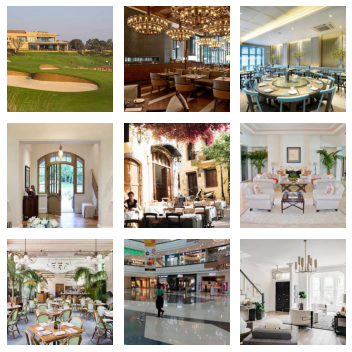

In [35]:
path = "/content/bgfgdataset/bg"
print("File structure:")
list_files(path)
files = os.listdir(path)
print("File count:", len(files))
print("Image dimensions:", imsize(path+"/"+files[0]))
print("Dir size:", du(path),"\n")
!mkdir /content/bg_wrap
!cp -r /content/bgfgdataset/bg /content/bg_wrap/
compute_mean_std("/content/bg_wrap", bs=128, is_gray=False)
!rm -rf /content/bg_wrap/
print()
display_grid(path, 9, ext=".jpg", sub_dirs=False, figsize=(5,5))

### Foreground

File structure:
fg/
    fg_092.png
    fg_017.png
    fg_068.png
    ...
File count: 99
Image dimensions: (140, 96, 4)
Dir size: 1.8M



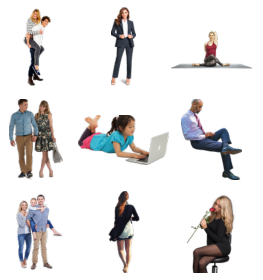

In [38]:
path = "/content/bgfgdataset/fg"
print("File structure:")
list_files(path)
files = os.listdir(path)
print("File count:", len(files))
print("Image dimensions:", imsize(path+"/"+files[0]))
print("Dir size:", du(path))
print()
display_grid(path, 9, ext=".png", sub_dirs=False, figsize=(4,4))

### Foreground Mask

File structure:
fg_mask/
    mask_fg_020.png
    mask_fg_081.png
    mask_fg_046.png
    ...
File count: 99
Image dimensions: (140, 65, 4)
Dir size: 848K



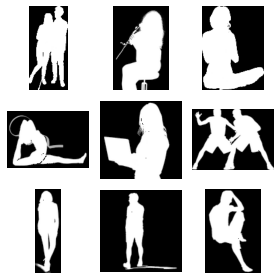

In [40]:
path = "/content/bgfgdataset/fg_mask"
print("File structure:")
list_files(path)
files = os.listdir(path)
print("File count:", len(files))
print("Image dimensions:", imsize(path+"/"+files[0]))
print("Dir size:", du(path))
print()
display_grid(path, 9, ext=".png", sub_dirs=False, figsize=(4,4))

### Foreground Overlayed on Background

In [4]:
path = "/content/bgfgdataset/bgfg_overlay/content/fg_bg_dataset"
print("File structure:")
list_files(path)
dirs = os.listdir(path)
print("Sub-dirs count:", len(dirs))
files = os.listdir(path+"/"+dirs[0])
print("Files per sub-dir count:", len(files))
print("Image dimensions:", imsize(path+"/"+dirs[0]+"/"+files[0]))
print("Dir size:", du(path),"\n")
compute_mean_std(path, bs=1024, is_gray=False)
print()
display_grid(path, 9, ext=".png", sub_dirs=True, figsize=(5,5), off=65)

File structure:
fg_bg_dataset/
    bgfg_overlay/
        ol_bg025fg0622f_fg_062.png
        ol_bg014fg0619_fg_061.png
        ol_bg021fg05313f_fg_053.png
        ...
Sub-dirs count: 1
Files per sub-dir count: 392041
Image dimensions: (224, 224, 3)
Dir size: 5.3G 



Computing std: 100%|██████████| 383/383 [26:05<00:00,  4.09s/it]



Mean:  tensor([0.5365, 0.4978, 0.4601])
Std:  tensor([0.2671, 0.2650, 0.2799])



IndexError: ignored

### Foreground Overlayed on Background Mask

In [6]:
path = "/content/bgfgdataset/bgfg_mask/content/fg_bg_dataset"
print("File structure:")
list_files(path)
dirs = os.listdir(path)
print("Sub-dirs count:", len(dirs))
files = os.listdir(path+"/"+dirs[0])
print("Files per sub-dir count:", len(files))
print("Image dimensions:", imsize(path+"/"+dirs[0]+"/"+files[0]))
print("Dir size:", du(path),"\n")
compute_mean_std(path, bs=1024, is_gray=True)
print()
display_grid(path, 9, ext=".png", sub_dirs=True, figsize=(5,5), off=65)

File structure:
fg_bg_dataset/
    bgfg_mask/
        mask_ol_bg082fg06116_fg_061.png
        mask_ol_bg082fg0934f_fg_093.png
        mask_ol_bg042fg08810f_fg_088.png
        ...
Sub-dirs count: 1
Files per sub-dir count: 392041
Image dimensions: (224, 224)
Dir size: 1.6G 



Computing std: 100%|██████████| 383/383 [04:33<00:00,  1.40it/s]



Mean:  tensor([0.0943])
Std:  tensor([0.2856])



IndexError: ignored

### Foreground Overlayed on Background Depth Map

File structure:
fg_bg_depth/
    bg_94/
        bg_94_fg_59_F_378383.jpg
        bg_94_fg_30_T_377226.jpg
        bg_94_fg_36_T_377442.jpg
        ...
    bg_08/
        bg_08_fg_83_T_035332.jpg
        bg_08_fg_63_T_034556.jpg
        bg_08_fg_55_F_034229.jpg
        ...
...
Sub-dirs count: 100
Files per sub-dir count: 4000
Image dimensions: (224, 224)
Dir size: 1.6G 



Computing std: 100%|██████████| 391/391 [04:56<00:00,  1.32it/s]



Mean:  tensor([0.4334])
Std:  tensor([0.2715])



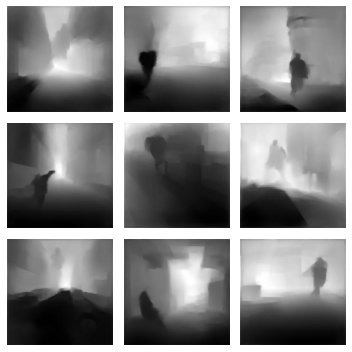

In [ ]:
path = "/content/bgfgdataset/fg_bg_depth"
print("File structure:")
list_files(path)
dirs = os.listdir(path)
print("Sub-dirs count:", len(dirs))
files = os.listdir(path+"/"+dirs[0])
print("Files per sub-dir count:", len(files))
print("Image dimensions:", imsize(path+"/"+dirs[0]+"/"+files[0]))
print("Dir size:", du(path),"\n")
compute_mean_std(path, bs=1024, is_gray=True)
print()
display_grid(path, 9, ext=".jpg", sub_dirs=True, figsize=(5,5), off=65)

In [ ]:
import shutil
output_fname = "/content/dataset"
dir_name = "/content/dataset"
shutil.make_archive(output_fname, 'zip', dir_name)

'/content/dataset.zip'

In [ ]:
!cp '/content/dataset.zip' '/content/gdrive/My Drive/mask_rcnn_dataset/'